In [12]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib
from matplotlib.axes import Axes
%matplotlib inline
import numpy as np
import pyvista as pv
from pyvista import examples
import pandas as pd
import xarray as xr
import time
import cartopy.crs as ccrs

pv.global_theme.jupyter_backend = 'pythreejs'

In [13]:
ds = xr.open_dataset('/scratch/project_2000789/muramarg/run_5_31/output_WAOM_check/ocean_flt.nc')
dt = xr.open_dataset('/scratch/project_2000789/muramarg/run_5_31/output_WAOM_check/ocean_avg_0001.nc')
#dd = xr.open_dataset('/scratch/project_2000789/muramarg/run_5_31/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10_frc/waom10extend_grd.nc')

In [14]:
x = (ds.variables['Xgrid'].values)
y = (ds.variables['Ygrid'].values)
z = (ds.variables['Zgrid'].values)

In [15]:
print(x.shape)

(23521, 3675)


In [16]:
def make_points(i):
    """Helper to make XYZ points"""
    z1 = list(z[:,i])
    x1 = list(x[:,i])
    y1 = list(y[:,i])
    return np.column_stack((x1, y1, z1))

In [17]:
def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pv.PolyData()
    poly.points = points
    cells = np.full((len(points) - 1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points) - 1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly


#line = lines_from_points(points)
#line

In [18]:
# dt.variables['zice'].values

## Attempts without looping

In [19]:
mask_rho = dt.variables['mask_rho']
zice = dt.variables['zice']
my_xarr = zice*mask_rho
zpts = my_xarr.to_numpy()
#poly = pv.PolyData(zpts)
#grid = pv.create_grid(zpts)
#grid
#zpts.texture_map_to_plane(use_bounds=True, inplace=True)

In [20]:
 # zice points
def get_zice_points(zice):
    value = zice.to_numpy()
    x = np.arange(value.shape[0])
    y = np.arange(value.shape[1])
    xx, yy = np.meshgrid(x, y, sparse=False)
    xx = xx.reshape(-1, 1)
    xx = xx.flatten()
    yy = yy.reshape(-1, 1)
    yy = yy.flatten()
    value = value.reshape(-1, 1)
    value = value.flatten()
    value = (value)
    
    return (xx,yy,value)
# test = dt.variables['zice'].values
mask_rho = dt.variables['mask_rho']
zice = dt.variables['zice']
a = zice*mask_rho
xz,yz,zz = get_zice_points(a)

In [21]:
zz = zz/1000/10

In [22]:
# print(xz,yz,zz)
z_mesh = np.array([xz,yz,zz]).T
print(z_mesh.shape)

(352800, 3)


In [23]:
z_nonzero = [i for i in z_mesh if i[2] != 0]
z_nonzero = np.array(z_nonzero)
z_nonzero.shape

(19084, 3)

In [24]:
myz = pv.PolyData(z_mesh)
myz

PolyData,Information
N Cells,352800
N Points,352800
X Bounds,"0.000e+00, 5.590e+02"
Y Bounds,"0.000e+00, 6.290e+02"
Z Bounds,"-2.134e-01, 0.000e+00"
N Arrays,0


In [25]:
myz.plot()

/users/muramarg/.local/lib/python3.9/site-packages/pyvista/jupyter/pv_pythreejs.py:436: UserWarning: Empty or unsupported dataset attached to actor
  warnings.warn('Empty or unsupported dataset attached to actor')


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [26]:
dfx = z_nonzero[:,0]
dfy = z_nonzero[:,1]
dfz = z_nonzero[:,2]

data = {'X': z_mesh[:,0],
        'Y': z_mesh[:,1],
        'Z': z_mesh[:,2]}
 
# # Create DataFrame
df = pd.DataFrame(data)
coords = df[['X', 'Y', 'Z']].values

In [27]:
df

,X,Y,Z
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,2.0,0.0,0.0
3,3.0,0.0,0.0
4,4.0,0.0,0.0
...,...,...,...
352795,555.0,629.0,0.0
352796,556.0,629.0,0.0
352797,557.0,629.0,0.0
352798,558.0,629.0,0.0


In [28]:
structured = pv.StructuredGrid()
# Set coordinates
structured.points = coords
# Set the dimensions of the structured grid
structured.dimensions = [560, 630, 1]

# Apply an Elevation filter
# elevation = structured.elevation()
# elevation.plot()
structured.plot()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [29]:
p = pv.Plotter()
p.add_mesh(myz)
p.show()
#myz.plot()

/users/muramarg/.local/lib/python3.9/site-packages/pyvista/jupyter/pv_pythreejs.py:436: UserWarning: Empty or unsupported dataset attached to actor
  warnings.warn('Empty or unsupported dataset attached to actor')


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

## Plotting by looping

In [30]:
# zice points
def get_zice_points(zice):
    x = np.array([])
    y = np.array([])
    z = np.array([])
    for i in range(len(zice)):
        for j in range(len(zice[i])):
            if zice[i][j] != 0:
                x = np.append(x,j)
                y = np.append(y,i)
                z = np.append(z,zice[i][j]/1000/10)
                
    return x,y,z
test = dt.variables['zice'].values
xz,yz,zz = get_zice_points(test)

In [31]:
zz = zz/1000/10

In [32]:
zpts = np.array([xz,yz,zz]).T
#print(zpts)

In [33]:
point_cloud = pv.PolyData(zpts)
point_cloud

PolyData,Information
N Cells,119793
N Points,119793
X Bounds,"4.600e+01, 5.740e+02"
Y Bounds,"8.500e+01, 5.230e+02"
Z Bounds,"-2.534e-05, -3.069e-14"
N Arrays,0


In [34]:
pv.global_theme.jupyter_backend = 'pythreejs'
point_cloud.plot()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

## Plotting with ccrs normally

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.scatter(zpts[:, 0], zpts[:, 1], c=zpts[:, 2])
# plt.axis("image")
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.colorbar()
# plt.show()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


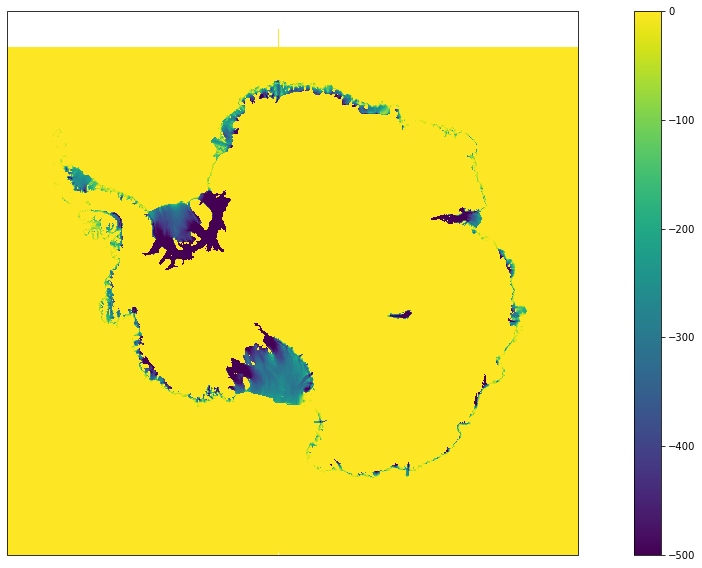

In [35]:
#plt.figure(figsize=(10, 10))
# masking land points
mask_rho = dt.variables['mask_rho']
zice = dt.variables['zice']

proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
#plt.scatter(zpts[:, 0], zpts[:, 1], c=zpts[:, 2])
# another way
plt.pcolormesh(dg.lon_rho,dg.lat_rho, zice*mask_rho,transform=ccrs.PlateCarree(), vmin=-500, vmax=0)
plt.axis("image")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.colorbar()
plt.show()

In [36]:
# point_cloud = pv.PolyData(zpts)
point_cloud = pv.PolyData(zpts)
point_cloud

PolyData,Information
N Cells,119793
N Points,119793
X Bounds,"4.600e+01, 5.740e+02"
Y Bounds,"8.500e+01, 5.230e+02"
Z Bounds,"-2.534e-05, -3.069e-14"
N Arrays,0


In [37]:
# pv.global_theme.jupyter_backend = 'pythreejs'
pv.global_theme.jupyter_backend = 'pythreejs'

## plotting splines without addition of zice

In [38]:
def cast_all_points():
    #pv.start_xvfb()
    start_time = time.time()
    network = pv.MultiBlock()
    network.add_field_data(np.arange(x.shape[0]/900),"time")
    
    # add backend
    
    for i in range(0,10):
        if (i%5 ==0):
            print(i,'/ 105','in',(time.time()-start_time)/60)
        points = make_points(i)
        line = lines_from_points(points)
        line["days since start"] = np.arange(line.n_points)
        tube = line.tube(radius=0.1)
        network.append(tube)
        #line['time'] = np.arange(x.shape[0])
        
        #tube.plot(smooth_shading=True)
        
    # create the scalar bars and plot
    print('ok')
    
    p = pv.Plotter()
    sargs = dict(
        n_labels=0,
        label_font_size = 14
    )
    annotations = {
        0:'0',2820: '30', 5640: '60', 8460:'90',11280: '120', 14100:'150', 16920:'180',
        19740:'210', 22560:'240',   
    }
    #_ = p.add_mesh(network, smooth_shading=True,annotations=annotations, scalar_bar_args=sargs)
    _ = p.add_mesh(network, smooth_shading=True,show_scalar_bar=True,annotations=annotations,scalar_bar_args=sargs)
    #network.plot(show_scalar_bar=True)
    #_ = p.add_scalar_bar(n_labels=0,label_font_size=14,above_label=annotations)
    
    # add the zice shape
    print('plotting')
    # add the plot axes
    _ = p.add_axes(line_width=5, xlabel='x',ylabel='y',zlabel='z',viewport=(0,0,200,200))
    p.show(auto_close=False)
    #p.save_graphic("testing.svg") 
    print('total time:',(time.time()-start_time)/60,'min')
cast_all_points()

0 / 105 in 0.00039312044779459633
5 / 105 in 0.01955617666244507
ok
plotting


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

total time: 0.17574191490809124 min


## plotting with attempted addition of zice

In [40]:
def cast_all_points(zpts):
    start_time = time.time()
    network = pv.MultiBlock()
    network.add_field_data(np.arange(x.shape[0]/900),"time")
    #print(network)
    for i in range(0,10):
        if (i%5 ==0):
            print(i,'/ 105','in',(time.time()-start_time)/60)
        points = make_points(i)
        line = lines_from_points(points)
        line["days since start"] = np.arange(line.n_points)
        tube = line.tube(radius=0.1)
        network.append(tube)
        #line['time'] = np.arange(x.shape[0])
        
        #tube.plot(smooth_shading=True)
        
    # create the scalar bars and plot
    p = pv.Plotter()
    sargs = dict(
        n_labels=0,
        label_font_size = 14
    )
    annotations = {
        0:'0',2820: '30', 5640: '60', 8460:'90',11280: '120', 14100:'150', 16920:'180',
        19740:'210', 22560:'240',   
    }
    p.add_mesh(network, smooth_shading=True,annotations=annotations, scalar_bar_args=sargs)
    
    # add the zice shape
    point_cloud = pv.PolyData(zpts)
    p.add_mesh(point_cloud,smooth_shading=True,color='#a8a8a8')
    
    
    # add the plot axes
    _ = p.add_axes(line_width=5, labels_off=False)
    #_ = p.enable_eye_dome_lighting()
    p.show()
    print('total time:',(time.time()-start_time)/60,'min')
cast_all_points(zpts)

0 / 105 in 4.1604042053222655e-06
5 / 105 in 0.01761853297551473


/users/muramarg/.local/lib/python3.9/site-packages/pyvista/jupyter/pv_pythreejs.py:436: UserWarning: Empty or unsupported dataset attached to actor
  warnings.warn('Empty or unsupported dataset attached to actor')


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

total time: 0.17025843461354573 min


In [ ]:
# def make_points(i):
#     """Helper to make XYZ points"""
#     z1 = list(z[:,i])
#     x1 = list(x[:,i])
#     y1 = list(y[:,i])
#     return np.column_stack((x1, y1, z1))
# points = make_points(1)
# line = lines_from_points(points)

In [ ]:
# line["scalars"] = np.arange(line.n_points)
# tube = line.tube(radius=0.1)
# tube.plot(smooth_shading=True)

In [ ]:
# p = pv.Plotter()
# p.add_mesh(stream.tube(radius=0.0015))
# p.view_xy()
# p.show(cpos=cpos)